In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [5]:
companies = pd.read_csv('./merged/aged_comp2008.csv')  # Replace 'your_data.csv' with the path to your data file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196554 entries, 0 to 196553
Data columns (total 66 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         196554 non-null  float64
 1   entity_type                196554 non-null  float64
 2   name                       196554 non-null  float64
 3   category_code              196554 non-null  float64
 4   status                     196554 non-null  float64
 5   founded_at                 196554 non-null  float64
 6   closed_at                  196554 non-null  float64
 7   domain                     196554 non-null  float64
 8   homepage_url               196554 non-null  float64
 9   twitter_username           196554 non-null  float64
 10  short_description          196554 non-null  float64
 11  description                196554 non-null  float64
 12  overview                   196554 non-null  float64
 13  tag_list                   19

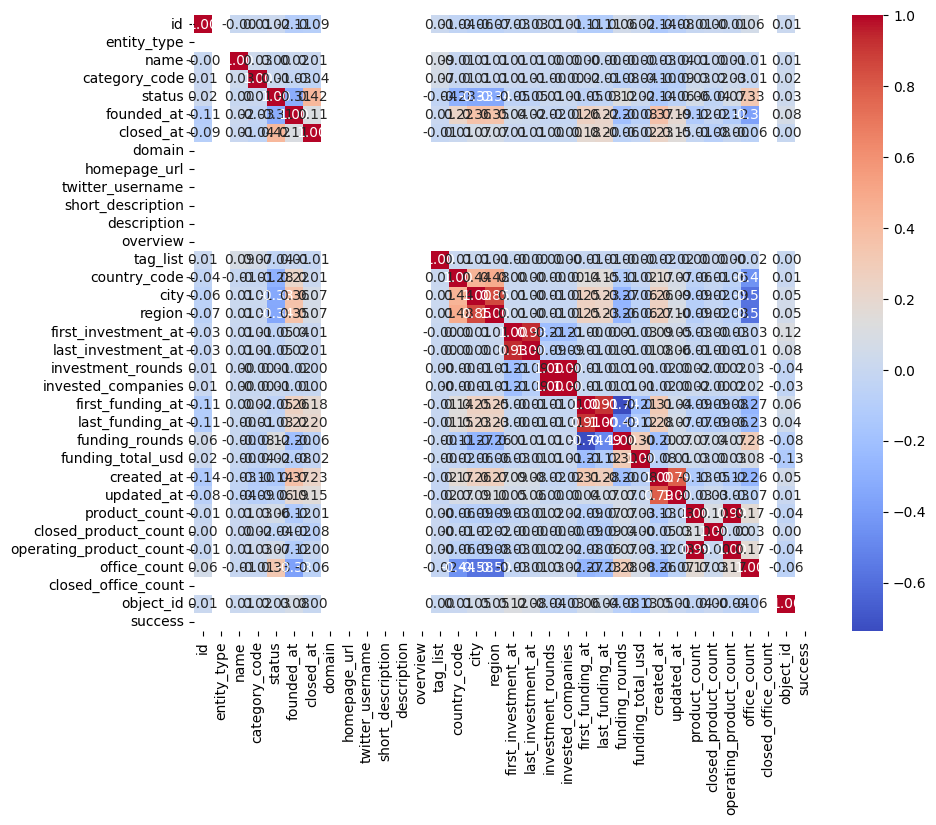

ValueError: list.remove(x): x not in list

In [62]:
companies['success'] = ((companies['status'].isin(['ipo', 'acquired'])) |
                 (companies['acquiring_object_id'].notna()) |  # Assuming this column indicates acquiring others
                 (companies[['angel', 'crowdfunding', 'other', 'post_ipo', 'private_equity', 'series_a', 'series_b', 'series_c', 'venture']].sum(axis=1) > 0) |
                 (companies['funding_total_usd'] > 0)).astype(int)

# Basic EDA
print(companies.info())
print(companies.describe())


# Exclude non-numeric columns for correlation analysis
numeric_df = companies.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(
    ['funded_object_id', 'num_of_companies_financed', 'startup_financed', 'log_fund_tot', 'tot_fin', 'target', 'num_of_fin_org_financed',
    'fin_org_financed', 'funded_object_id_y', 'num_of_person_financed', 'person_financed', 'acquiring_object_id', 'number_of_acq_companies', 
    'acquired_object_id', 'have_been_acquired', 'funded_object_id_x', 'series_a', 'series_b', 'series_c', 'venture', 'crowdfunding', 'other', 
    'post_ipo', 'private_equity', 'raised_currency_code', 'public_at', 'stock_symbol', 'angel', 'valuation_amount', 'valuation_currency_code', 
    'raised_amount', 'operating_office_count'], axis=1)

# Correlation Analysis
corr_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Feature Selection based on correlation and domain knowledge
selected_features = corr_matrix['success'][abs(corr_matrix['success']) > 0.5].index.tolist()
selected_features.remove('success')  # Remove the target variable

print(f"Selected features based on correlation: {selected_features}")


In [63]:
# Calculate the absolute correlation with 'success'
abs_corr_with_success = corr_matrix['success'].abs().sort_values(ascending=False)

# Exclude 'success' itself from the list
abs_corr_with_success = abs_corr_with_success[abs_corr_with_success.index != 'success']

# Calculate the number of features to select for top and bottom 85%
top_bottom_threshold = int(len(abs_corr_with_success) * 0.10)

# Select the top 85% of features
top_features = abs_corr_with_success[:top_bottom_threshold].index.tolist()

# Select the bottom 85% of features (note: there will be overlap if not exactly divisible)
bottom_features = abs_corr_with_success[-top_bottom_threshold:].index.tolist()

print(f"Top 85% of selected features based on correlation with success: {top_features}")
print(f"Bottom 85% of selected features based on correlation with success: {bottom_features}")

Top 85% of selected features based on correlation with success: ['id', 'entity_type', 'name']
Bottom 85% of selected features based on correlation with success: ['office_count', 'closed_office_count', 'object_id']


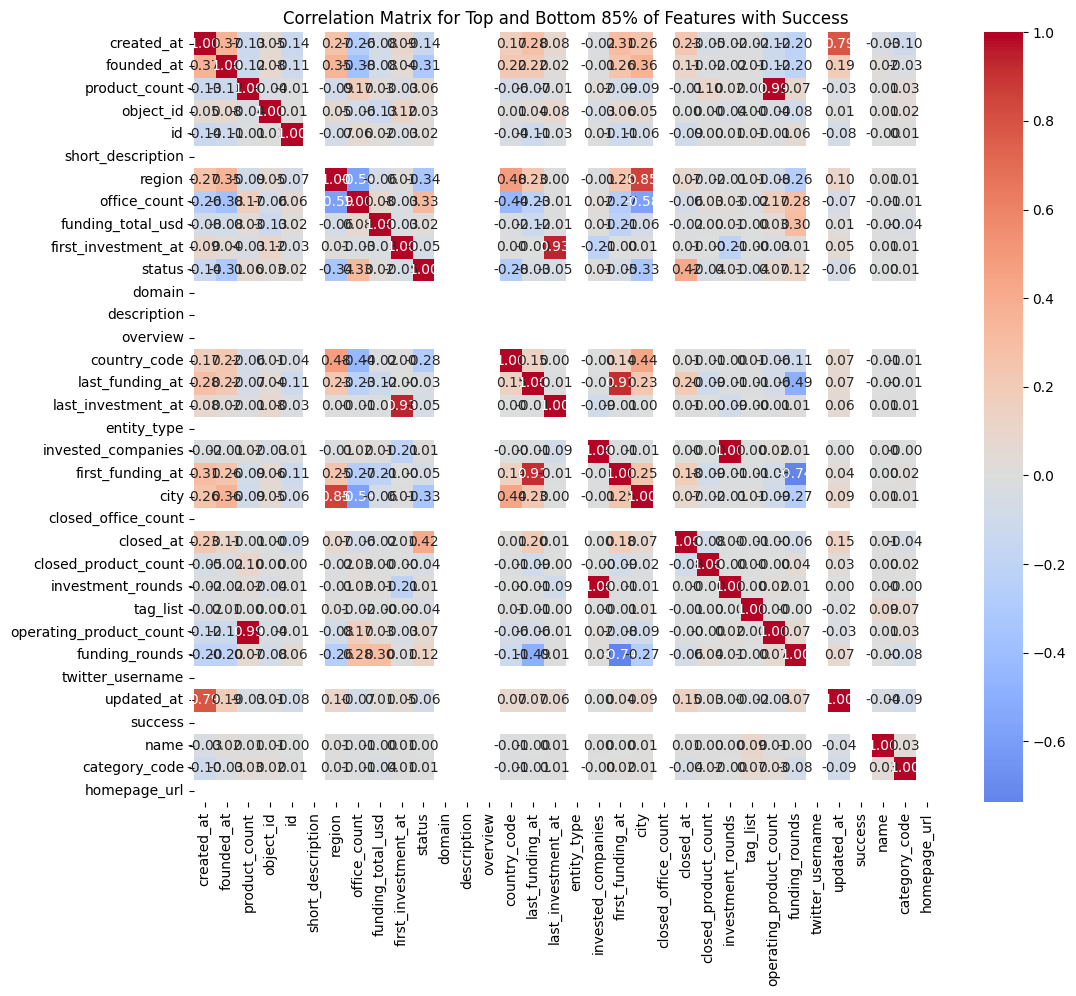

In [64]:

# Calculate the absolute correlation with 'success'
abs_corr_with_success = corr_matrix['success'].abs().sort_values(ascending=False)

# Exclude 'success' itself from the list
abs_corr_with_success = abs_corr_with_success[abs_corr_with_success.index != 'success']

# Calculate the number of features to select for top and bottom 85%
top_bottom_threshold = int(len(abs_corr_with_success) * 0.6)

# Select the top 85% of features
top_features = abs_corr_with_success[:top_bottom_threshold].index.tolist()

# Select the bottom 85% of features
bottom_features = abs_corr_with_success[-top_bottom_threshold:].index.tolist()

# Create a list that combines top and bottom features for the heatmap, avoiding duplicates
combined_features = list(set(top_features + bottom_features + ['success']))

# Filter the correlation matrix for the combined features
filtered_corr_matrix = corr_matrix.loc[combined_features, combined_features]

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix for Top and Bottom 85% of Features with Success")
plt.show()


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer

In [67]:

# Define the target variable based on your criteria
# companies['target'] = ((companies['status'].isin(['ipo', 'acquired'])) | 
#                 (companies['acquiring_object_id'].notna()) |
#                 (companies[['angel', 'crowdfunding', 'other', 'post_ipo', 'private_equity', 'series_a', 'series_b', 'series_c', 'venture']].sum(axis=1) > 0) |
#                 (companies['funding_total_usd'] > 0)).astype(int)

# Handle missing values - impute numeric columns and fill categorical with a placeholder
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# 
numeric_df = numeric_df.drop(numeric_df['success'])

# numeric_df['target'] = ((numeric_df['status'].isin(['ipo', 'acquired'])) | 
#                 (numeric_df['acquiring_object_id'].notna()) |
#                 (numeric_df[['angel', 'crowdfunding', 'other', 'post_ipo', 'private_equity', 'series_a', 'series_b', 'series_c', 'venture']].sum(axis=1) > 0) |
#                 (numeric_df['funding_total_usd'] > 0)).astype(int)

for column in numeric_df.columns:
    if numeric_df[column].dtype == 'object':
        numeric_df[column] = categorical_imputer.fit_transform(numeric_df[[column]]).ravel()  # Use .ravel() to convert to 1D
    else:
        numeric_df[column] = numeric_imputer.fit_transform(numeric_df[[column]]).ravel()  # Use .ravel() to convert to 1D


# Encode categorical variables
label_encoders = {}
for column in numeric_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    numeric_df[column] = le.fit_transform(numeric_df[column])
    label_encoders[column] = le

# Feature Selection - Use the top and bottom 60% features identified earlier
features = combined_features  # This should be the list of features from the previous step

# Train-test split
x = numeric_df[features]
y = numeric_df['success']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     58966

    accuracy                           1.00     58966
   macro avg       1.00      1.00      1.00     58966
weighted avg       1.00      1.00      1.00     58966



In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Assume 'companies' has been prepared with the target variable 'success' as previously discussed

# Advanced Imputation
iterative_imputer = IterativeImputer(random_state=42)
imputed_data = iterative_imputer.fit_transform(companies.select_dtypes(include=[np.number]))
df_imputed = pd.DataFrame(imputed_data, columns=companies.select_dtypes(include=[np.number]).columns)

# Encode categorical variables
for column in companies.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_imputed[column] = le.fit_transform(companies[column].fillna('Missing'))

# Feature selection
features = combined_features  # Assuming 'combined_features' is defined from your previous analysis

# Train-test split
X = df_imputed[features]
y = df_imputed['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Enhancement: Random Forest with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best model from random search
best_rf = random_search.best_estimator_

# Predictions and Evaluation
y_pred = best_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

# Note: Model interpretability with SHAP values would typically involve creating a SHAP explainer and calculating SHAP values for the test set.
# Due to its complexity and computational requirements, we're not including the actual SHAP implementation in this snippet.


Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30190
         1.0       1.00      1.00      1.00      4522

    accuracy                           1.00     34712
   macro avg       1.00      1.00      1.00     34712
weighted avg       1.00      1.00      1.00     34712



Class Distribution:
 target
0.0    100908
1.0     14798
Name: count, dtype: int64


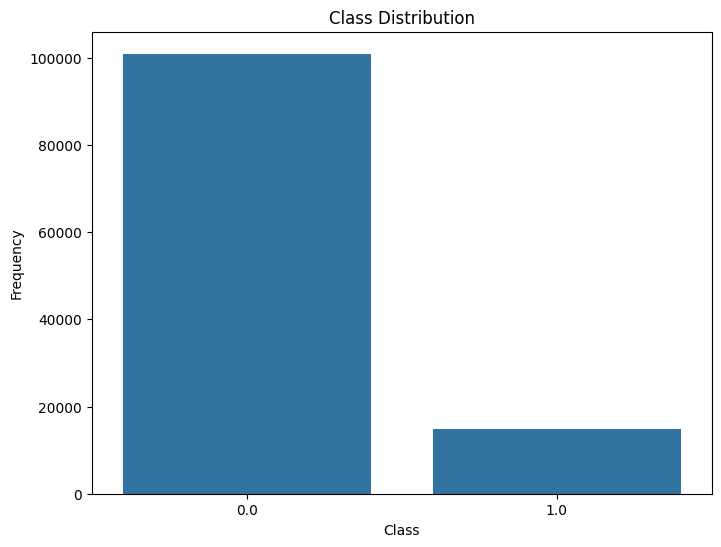

Class Weights:
 {0.0: 0.5733242161176517, 1.0: 3.9095147992972024}


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# Analyze class distribution
class_distribution = companies['target'].value_counts()
print("Class Distribution:\n", class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Calculate class weights (useful for addressing class imbalance in model training)
weights = class_weight.compute_class_weight('balanced', classes=companies['target'].unique(), y=companies['target'])
class_weights = dict(zip(companies['target'].unique(), weights))

print("Class Weights:\n", class_weights)


In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming 'X' is your feature set and 'y' is the target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(companies.drop('target', axis=1), companies['target'], test_size=0.3, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the new class distribution
print("New class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())


New class distribution after SMOTE:
 target
0.0    70718
1.0    70718
Name: count, dtype: int64


In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming 'companies' is your DataFrame and it includes the target variable 'target'

# Define features (X) and target (y)
X = companies.drop('target', axis=1)
y = companies['target']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the new class distribution after SMOTE
print("New class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

# Predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


New class distribution after SMOTE:
 target
0.0    70718
1.0    70718
Name: count, dtype: int64
Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30190
         1.0       1.00      1.00      1.00      4522

    accuracy                           1.00     34712
   macro avg       1.00      1.00      1.00     34712
weighted avg       1.00      1.00      1.00     34712

